In [79]:
from os import walk 
from os.path import join
import numpy as np 
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup 

from sklearn import svm
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate, ShuffleSplit

import gensim
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image

from collections import Counter

%matplotlib inline 

In [80]:
SPAM_1_FILEPATH = 'UniversityProject_SpamFilter/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_FILEPATH = 'UniversityProject_SpamFilter/01_Processing/spam_assassin_corpus/spam_2'
HAM_1_FILEPATH = 'UniversityProject_SpamFilter/01_Processing/spam_assassin_corpus/ham_1'
HAM_2_FILEPATH = 'UniversityProject_SpamFilter/01_Processing/spam_assassin_corpus/ham_2'

SPAM_CAT = 1
HAM_CAT = 0

CUSTOM_FONT = 'UniversityProject_SpamFilter/wordcloud_resources/OpenSansCondensed-Bold.ttf'
WORD_CLOUD = 'UniversityProject_SpamFilter/wordcloud_resources/word_cloud.png'
THUMBS_UP = 'UniversityProject_SpamFilter/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN = 'UniversityProject_SpamFilter/wordcloud_resources/thumbs-down.png'
X_ICON = 'UniversityProject_SpamFilter/wordcloud_resources/x-icon.png'

In [81]:
def email_body_generator(path): 
                                    #walk provides a tuple 
    for root, dirnames, filenames, in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            stream = open(filepath, encoding='latin-1')
            is_body= False
            lines = []
            
            #extracts email body 
            for line in stream: 
                if is_body: 
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            
            #loops over the file in the directory and returns the file name and associated email body 
            yield file_name, email_body

In [82]:
def dataframe_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name) 
    
    return pd.DataFrame(rows, index=row_names) 

In [83]:
spam_emails = dataframe_from_directory(SPAM_1_FILEPATH, SPAM_CAT)
spam_emails = spam_emails.append(dataframe_from_directory(SPAM_2_FILEPATH, SPAM_CAT))
ham_emails = dataframe_from_directory(HAM_1_FILEPATH, HAM_CAT)
ham_emails = ham_emails.append(dataframe_from_directory(HAM_2_FILEPATH, HAM_CAT))
data = pd.concat([spam_emails, ham_emails])

In [6]:
#len(spam_emails)

1898

In [7]:
#len(ham_emails)

3901

In [56]:
eighty = round(len(data)*.8)
seventy = round(len(data)*.7)
sixty = round(len(data)*.6)
fifty = round(len(data)*.5)
forty = round(len(data)*.4)


In [78]:
# # scikit-learn bootstrap
# from sklearn.utils import resample
# # data sample
# # prepare bootstrap sample
# #resample(data, numberofsamples, how many to skip )
# boot = resample(data, replace=False, n_samples=eighty, random_state=5)
# #print('Bootstrap Sample: %s' % boot)
# # out of bag observations
# # oob = [x for x in data if x not in boot]
# # print('OOB Sample: %s' % oob)
# if data not in boot: 
#     print(x)

In [84]:
data[data.MESSAGE.str.len() == 0].index
data.drop(['cmds'], inplace = True)

In [85]:
data['length']=data['MESSAGE'].apply(len)


In [86]:
amount_of_SPAM = data.CATEGORY.value_counts()[1]
amount_of_HAM = data.CATEGORY.value_counts()[0]

In [87]:
amount_of_SPAM

1896

In [88]:
amount_of_HAM

3900

In [89]:
count = amount_of_SPAM+amount_of_HAM
count

5796

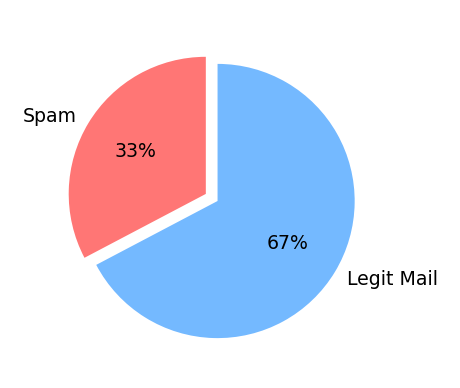

In [90]:
category_names =['Spam', 'Legit Mail']
size = [amount_of_SPAM, amount_of_HAM]
custom_colours = ['#ff7675', '#74b9ff']
plt.figure(figsize=(2, 2), dpi=227)
plt.pie(size, labels = category_names, textprops={'fontsize':6}, startangle=90, 
        autopct='%1.0f%%', colors = custom_colours, explode=[0,0.1])
plt.show()

In [91]:
documents_ids = range(0, len(data.index))
data['Doc_ID'] = documents_ids
data['File_Name'] = data.index
data = data.set_index('Doc_ID')
data.head()

,MESSAGE,CATEGORY,length,File_Name
Doc_ID,,,,
0,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1,612,00249.5f45607c1bffe89f60ba1ec9f878039a
1,ATTENTION: This is a MUST for ALL Computer Use...,1,1298,00373.ebe8670ac56b04125c25100a36ab0510
2,This is a multi-part message in MIME format.\n...,1,6691,00214.1367039e50dc6b7adb0f2aa8aba83216
3,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1,1141,00210.050ffd105bd4e006771ee63cabc59978
4,This is the bottom line. If you can GIVE AWAY...,1,1795,00033.9babb58d9298daa2963d4f514193d7d6


----------------------------------------------------------------------------------------------------------------------
Examples of stop words in English are “a”, “the”, “is”, “are” and etc. 
Removing stop words is done to eliminate words that are so commonly used that they carry very little useful information.

The below, is adding multiple dictionaries from different libraries together, in addition to common html words found in the messages.

----------------------------------------------------------------------------------------------------------------------

In [92]:
sklearn_stopwords = set(text.ENGLISH_STOP_WORDS)
gensim_stopwords = set(gensim.parsing.preprocessing.STOPWORDS)
nltk_stop_words = stopwords.words('english')

gensim_and_sklearn = sklearn_stopwords.union(gensim_stopwords)
libary_stopwords = gensim_and_sklearn.union(nltk_stop_words)

all_stop_words = {'url', 'http', '\n', '[html', 'html', 'tr', 'td', 'https', 'br', 'ign', 'err', 'mpt','[', ']' }
all_stop_words.update(libary_stopwords)

capital_sw = [each_string.title() for each_string in all_stop_words]
uppercase_sw = [each_string.upper() for each_string in all_stop_words]

all_stop_words.update(capital_sw)
all_stop_words.update(uppercase_sw)

#print(all_stop_words)

In [93]:
def clean_msg_nohtml(message, #stemmer = PorterStemmer(),
                  stop_words = set(all_stop_words)): 
    
    # Remove HTML tags 
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    #splits up  the individual words
    words = word_tokenize(cleaned_text)
    
    filtered_words = []
    
    for word in words: 
        if word not in stop_words and word.isalpha():
            filtered_words.append(word)
    
    return filtered_words

# DATA VISUALISATION

In [73]:
nested_list = data.MESSAGE.apply(clean_msg_nohtml)

/Users/rachaeldoherty/opt/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [ ]:
nested_list

In [74]:
docs_id_SPAM = data[data.CATEGORY ==1].index
docs_id_HAM = data[data.CATEGORY ==0].index

nested_list_HAM = nested_list.loc[docs_id_HAM]
nested_list_SPAM = nested_list.loc[docs_id_SPAM]
flat_list_HAM = [item for sublist in nested_list_HAM for item in sublist]

#total number of unique words in the non spam messages
HAM_words = pd.Series(flat_list_HAM).value_counts() 
flat_list_SPAM = [item for sublist in nested_list_SPAM for item in sublist]

#total number of unique words in the spam messages
SPAM_words = pd.Series(flat_list_SPAM).value_counts() 

In [75]:
SPAM_str = ' ' .join(flat_list_SPAM)
HAM_str = ' ' .join(flat_list_HAM)
full_str = SPAM_str + HAM_str

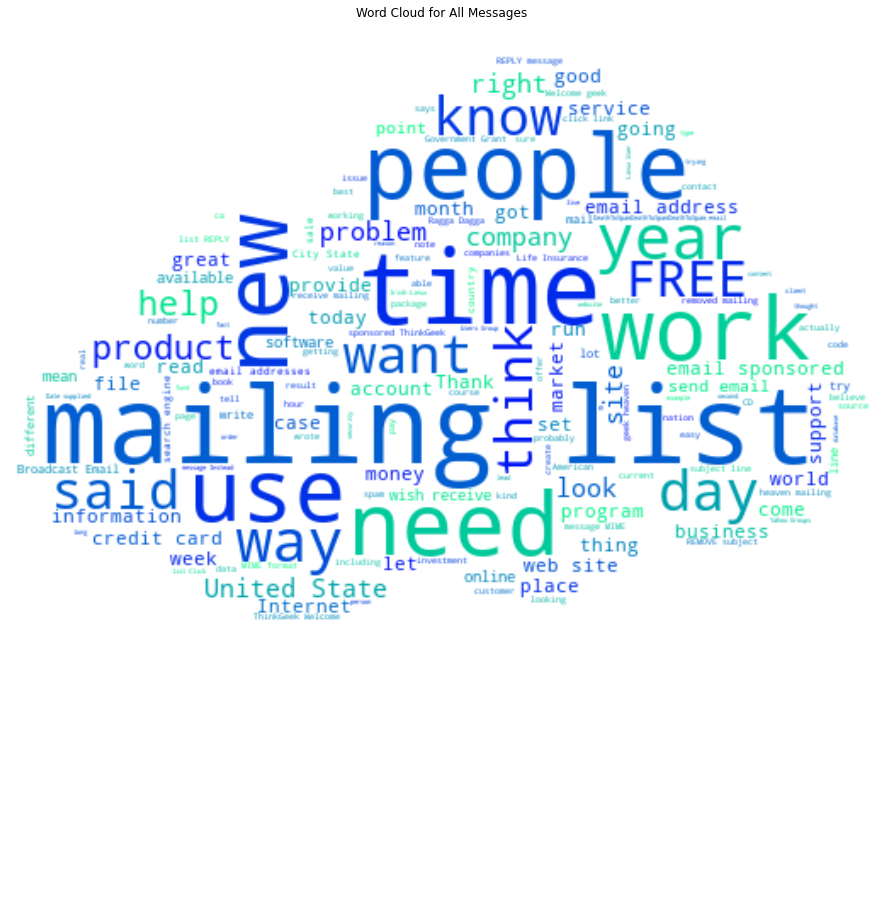

In [76]:
icon = Image.open(WORD_CLOUD)
image_mask = Image.new(mode = 'RGB', size = icon.size, color=(255,255,255))
image_mask.paste(icon, box = icon) 

rgb_array = np.array(image_mask) #converts the image object to an array 

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                       max_words = 1000, colormap = 'winter')

word_cloud.generate(full_str)

plt.figure(figsize=[32,16])
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.title('Word Cloud for All Messages')
plt.axis('off')
plt.show()

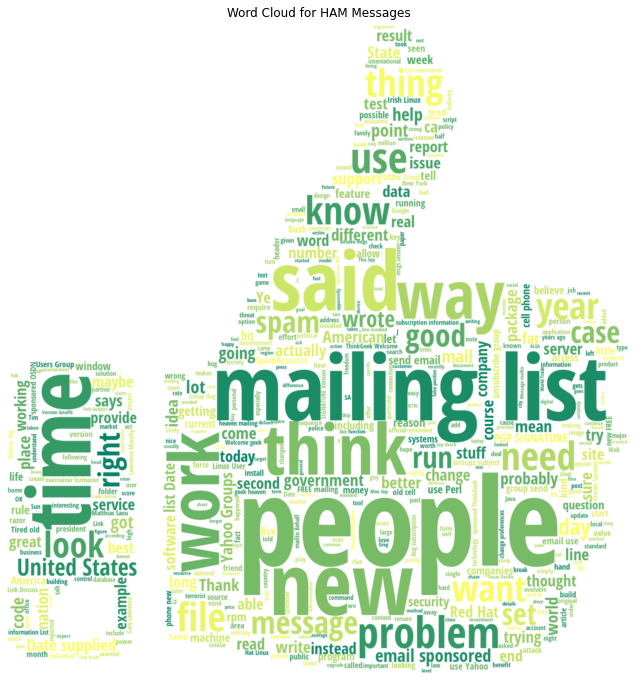

In [77]:
icon = Image.open(THUMBS_UP)
image_mask = Image.new(mode = 'RGB', size = icon.size, color=(255,255,255))
image_mask.paste(icon, box = icon) 

rgb_array = np.array(image_mask) #converts the image object to an array 


word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                       max_words = 500, colormap = 'summer',
                       font_path = CUSTOM_FONT, max_font_size = 300)

word_cloud.generate(HAM_str)

plt.figure(figsize=[20,12])
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.title('Word Cloud for HAM Messages')

plt.axis('off')
plt.show()

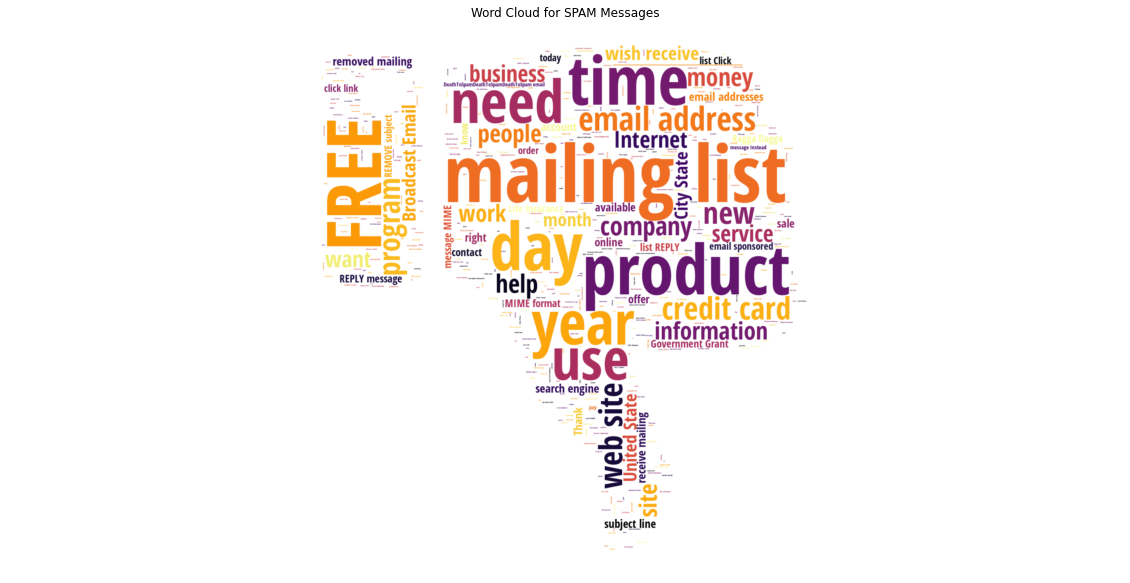

In [78]:
icon = Image.open(THUMBS_DOWN)
image_mask = Image.new(mode = 'RGB', size = icon.size, color=(255,255,255))
image_mask.paste(icon, box = icon) 

rgb_array = np.array(image_mask) #converts the image object to an array 

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                       max_words = 500, colormap = 'inferno', 
                       font_path = CUSTOM_FONT, max_font_size = 300)

word_cloud.generate(SPAM_str)

plt.figure(figsize=[20,12])
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.title('Word Cloud for SPAM Messages')
plt.axis('off')
plt.show()

### Distribution by Length of Text within both HAM and SPAM Messages: 

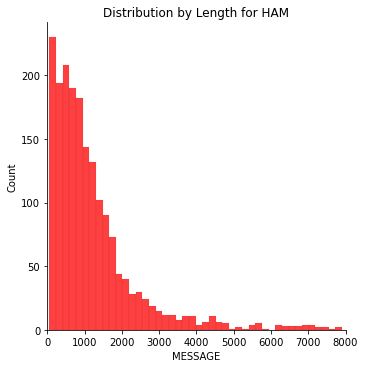

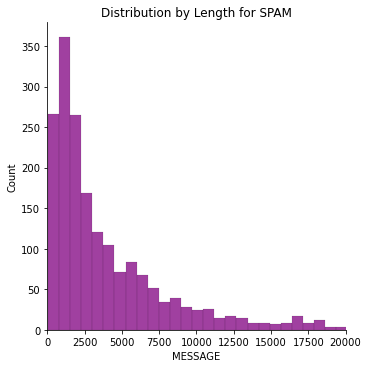

In [79]:
ham =data[data['CATEGORY'] == HAM_CAT]['MESSAGE'].str.len()
sns.displot(ham, label='Ham', color='red')
plt.xlim(0, 8000)
plt.title('Distribution by Length for HAM')

plt.draw()


spam = data[data['CATEGORY'] == SPAM_CAT]['MESSAGE'].str.len()
sns.displot(spam, label='Spam', color='purple')
plt.xlim(0, 20000)
plt.title('Distribution by Length for SPAM')
plt.draw()
plt.legend().set_visible(False)



# plt.savefig('Distrbution of word by length.png')
# transform/ normalise this range from 0 - 1 

In [ ]:
#SPAM_words[:10]

In [80]:
data1 = pd.DataFrame.from_dict(Counter(SPAM_str.split()).most_common(10))
data1 = data1.rename(columns={0: "words of spam", 1 : "count_"})

data2 = pd.DataFrame.from_dict(Counter(HAM_str.split()).most_common(10))
data2 = data2.rename(columns={0: "words of ham", 1 : "count_"})

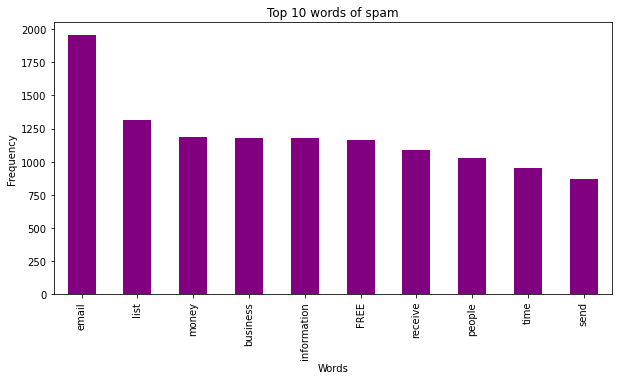

In [81]:
data1.plot.bar(legend = False, color = 'purple',figsize = (10,5))
y_pos = np.arange(len(data1["words of spam"]))
plt.xticks(y_pos, data1["words of spam"])
plt.title('Top 10 words of spam')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.legend().set_visible(False)
plt.show()

#plt.savefig('Top 10 words spam.png',dpi=199)


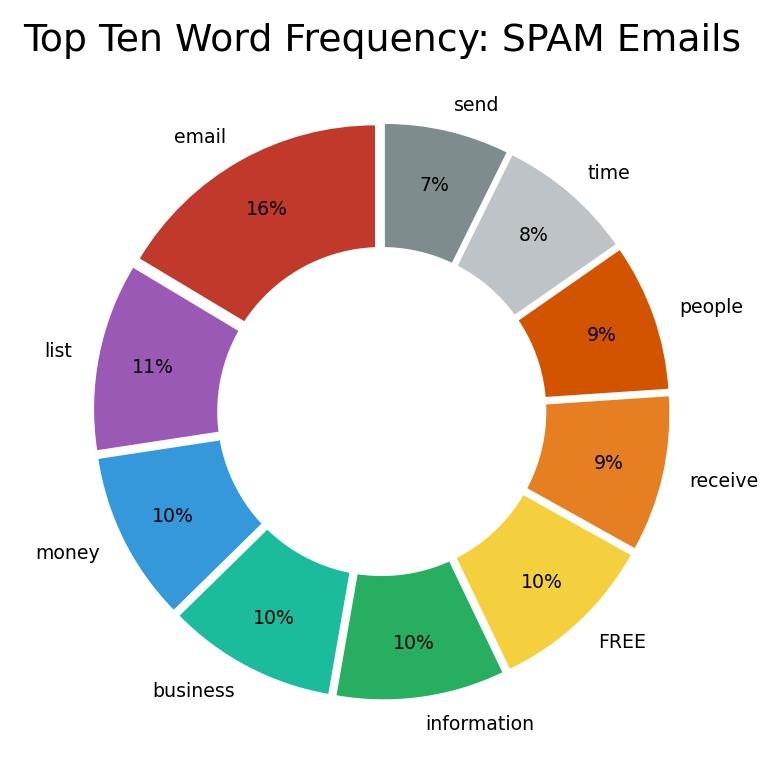

In [82]:
category_names = data1["words of spam"]

sizes = SPAM_words[:10]
custom_colours = ['#C0392B', '#9B59B6', '#3498DB', '#1ABC9C', '#27AE60', 
                  '#F4D03F', '#E67E22','#D35400', '#BDC3C7', '#7F8C8D']

#to "explode"
offset = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(4, 4), dpi=227)
plt.pie(sizes, labels = category_names, textprops={'fontsize':6}, startangle=90, 
        autopct='%1.0f%%', colors = custom_colours,  pctdistance = 0.8, explode = offset)


#draw circle
centre_circle = plt.Circle((0,0), radius = 0.6, fc='white')
plt.gca().add_artist(centre_circle)


#title

plt.title('Top Ten Word Frequency: SPAM Emails')

plt.show()

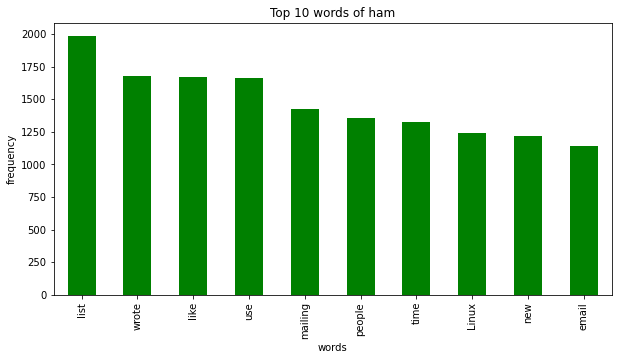

In [22]:
data2.plot.bar(legend = False, color = 'green', figsize = (10,5))
y_pos = np.arange(len(data2["words of ham"]))
plt.xticks(y_pos, data2["words of ham"])
plt.title('Top 10 words of ham')
plt.xlabel('words')
plt.ylabel('frequency')
#plt.draw()
plt.legend().set_visible(False)

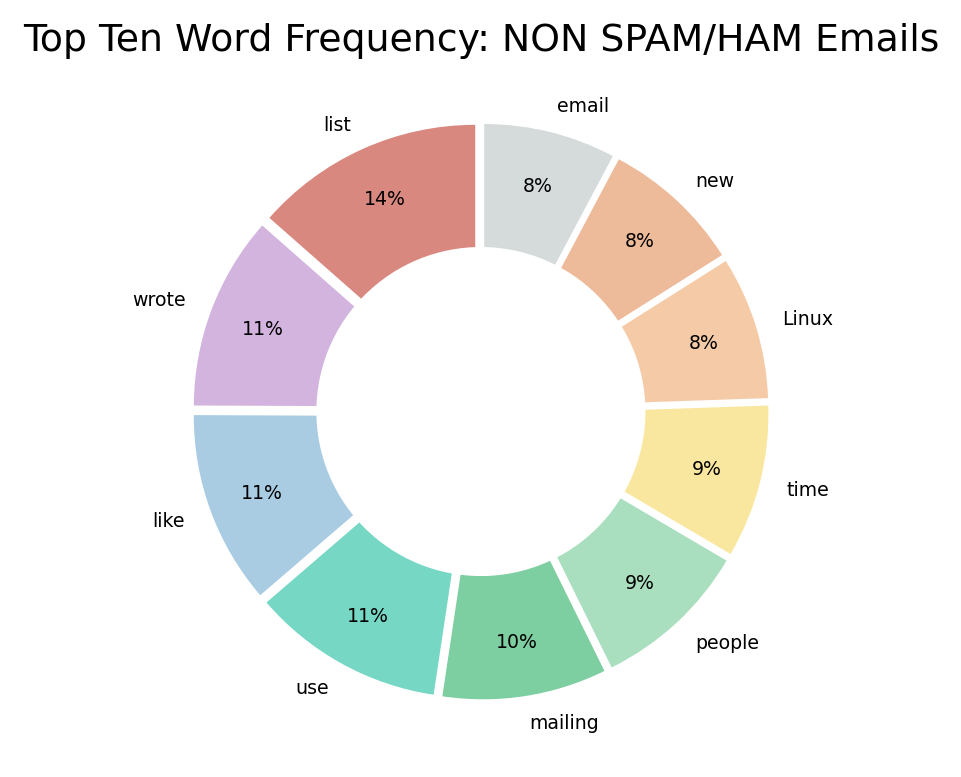

In [23]:
category_names = data2["words of ham"]
#category_names = [word.upper() for word in category_names]

sizes = HAM_words[:10]
custom_colours = ['#D98880', '#D2B4DE', '#A9CCE3', '#76D7C4', '#7DCEA0', 
                  '#A9DFBF', '#F9E79F','#F5CBA7', '#EDBB99', '#D5DBDB']

#to "explode"
offset = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]

def absolute_value(val):
    a  = sizes[ numpy.abs(sizes - val/100.*sizes.sum()).argmin() ]
    return a

plt.figure(figsize=(4, 4), dpi=227)

plt.pie(sizes, labels = category_names, textprops={'fontsize':6}, startangle=90, 
        autopct='%1.0f%%', colors = custom_colours,  pctdistance = 0.8, explode = offset)


#draw circle
centre_circle = plt.Circle((0,0), radius = 0.6, fc='white')
plt.gca().add_artist(centre_circle)


#title
plt.title('Top Ten Word Frequency: NON SPAM/HAM Emails')

plt.show()

----------------------------------------------------------------------------------------------------------------------

# Data using Random Under Sampler to confirm the data is equal & Create the Classifier

----------------------------------------------------------------------------------------------------------------------

In [97]:
from imblearn.under_sampling import  RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
equal_data, equal_data['CATEGORY']=rus.fit_resample(data[['MESSAGE']],data['CATEGORY'])
print('Data Equal for each Category:')
print(equal_data.value_counts('CATEGORY'))

Data Equal for each Category:
CATEGORY
0    1896
1    1896
dtype: int64


In [98]:
X_train, X_test, y_train, y_test = train_test_split(equal_data.MESSAGE, equal_data.CATEGORY, 
                                                    test_size=0.3, random_state=43)

#Vectorize the data: 
tfidf_vectorizer = TfidfVectorizer(stop_words=all_stop_words, max_df=0.25) 
# TODO: understand the max_df number and how does it affect the vectorizer 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

Confusion Matrix


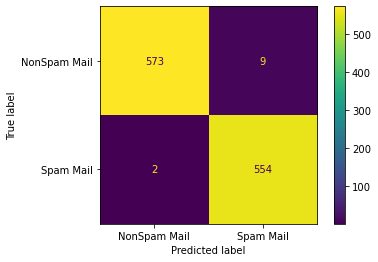

In [99]:
#Create the Classifier 
eq_data_spam_detector_svc = SGDClassifier().fit(tfidf_train, y_train)

#Train the Classifier
eq_data_predictions = eq_data_spam_detector_svc.predict(tfidf_test)

#Produce the Confusion Matrix
cm = confusion_matrix(eq_data_predictions, y_test)
target_names = ['NonSpam Mail', 'Spam Mail']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()
print("Confusion Matrix")
plt.draw()

In [101]:
#get the False Neg Rates: 
from sklearn.metrics import recall_score
tpr = recall_score(y_test, eq_data_predictions) 
tnr = recall_score(y_test, eq_data_predictions) 
fpr = 1 - tnr
fnr = 1 - tpr

print('False Negative Rate: {:.3f}%'.format(fnr))   #FNR for 1st class will be at index 0

False Negative Rate: 0.016%


In [102]:
print("Classificaion Report")

target_names = ['NonSpam Mail', 'Spam Mail']
print(classification_report(y_test, eq_data_predictions, digits=3, target_names=target_names))
cf = classification_report(y_test, eq_data_predictions, digits=3, target_names=target_names)

Classificaion Report
              precision    recall  f1-score   support

NonSpam Mail      0.985     0.997     0.990       575
   Spam Mail      0.996     0.984     0.990       563

    accuracy                          0.990      1138
   macro avg      0.990     0.990     0.990      1138
weighted avg      0.990     0.990     0.990      1138



In [103]:
correct_doc = (y_test == eq_data_predictions).sum()
numbs_doc_wrong = X_test.shape[0] - correct_doc
print('Docs classified correctly', correct_doc)
print('Docs classified incorrectly', numbs_doc_wrong)
accuracy = accuracy_score(y_test, eq_data_predictions)
print('SGD Classifier Accuracy of the Equally Distributed model: {:.3f}%'.format(accuracy*100))

Docs classified correctly 1127
Docs classified incorrectly 11
SGD Classifier Accuracy of the Equally Distributed model: 99.033%


----------------------------------------------------------------------------------------------------------------------

# Data in 4:1 split & Create the Classifier

----------------------------------------------------------------------------------------------------------------------

In [121]:
# Creating a dataframe with 80%
# values of original dataframe
part_80 = data.sample(frac = 0.80)
 
# Creating dataframe with
# rest of the 20% values
rest_part_20 = data.drop(part_80.index)
 
# print("\80% of the given DataFrame:")
# print(part_80)
 
# print("\nrest 20% of the given DataFrame:")
# print(rest_part_20)

In [122]:
X_train, X_test, y_train, y_test = train_test_split(part_80.MESSAGE, part_80.CATEGORY, 
                                                    test_size=0.3, random_state=43)

In [123]:
tfidf_vectorizer = TfidfVectorizer(stop_words=all_stop_words, max_df=0.25) 
# unstand the max_df number and how does it affect the vectorizer 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [124]:
spam_detector_svc_80 = SGDClassifier().fit(tfidf_train, y_train) 

In [125]:
predictions_80 = spam_detector_svc_80.predict(tfidf_test)

Confusion Matrix


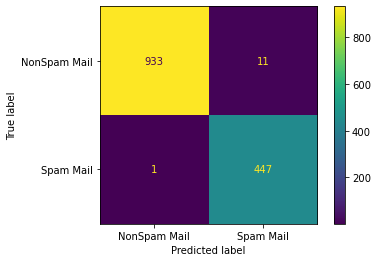

In [126]:
cm = confusion_matrix(predictions_80, y_test)
target_names = ['NonSpam Mail', 'Spam Mail']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()
print("Confusion Matrix")
plt.draw()

In [127]:
print("Classificaion Report")

target_names = ['NonSpam Mail', 'Spam Mail']
print(classification_report(y_test, predictions_80, digits=3, target_names=target_names))
cf = classification_report(y_test, predictions_80, digits=3, target_names=target_names)

Classificaion Report
              precision    recall  f1-score   support

NonSpam Mail      0.988     0.999     0.994       934
   Spam Mail      0.998     0.976     0.987       458

    accuracy                          0.991      1392
   macro avg      0.993     0.987     0.990      1392
weighted avg      0.991     0.991     0.991      1392



In [128]:
verify_tfidf_test_80 = tfidf_vectorizer.transform(rest_part_20.MESSAGE)
validation_80 = spam_detector_svc_80.predict(verify_tfidf_test_80)
verification_data_category_80 = rest_part_20.CATEGORY.to_numpy()
correct_doc_val_80 = (verification_data_category_80 == validation_80).sum()
numbs_doc_wrong_val_80 = verification_data_category_80.shape[0] - correct_doc_val_80
print('Docs classified correctly', correct_doc_val_80)
print('Docs classified incorrectly', numbs_doc_wrong_val_80)

Docs classified correctly 1149
Docs classified incorrectly 10


Confusion Matrix


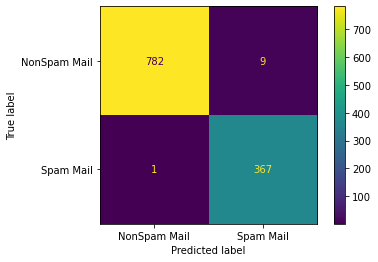

In [129]:
cm_validation_80 = confusion_matrix(validation_80, verification_data_category_80)
target_names = ['NonSpam Mail', 'Spam Mail']
disp = ConfusionMatrixDisplay(confusion_matrix=cm_validation_80, display_labels=target_names)
disp.plot()
print("Confusion Matrix")
plt.draw()

In [134]:
len(part_80)

4637

In [135]:
eighty

4639

----------------------------------------------------------------------------------------------------------------------
Bootstrapping using 
Cross Validation
----------------------------------------------------------------------------------------------------------------------

In [107]:
# # scikit-learn bootstrap
# data_boot = data
# from sklearn.utils import resample

# # prepare bootstrap sample
# boot = resample(data_boot, replace=True, n_samples=eighty, random_state=1)
# #print('Bootstrap Sample: %s' % boot)
# # out of bag observations
# outofbag = [x for x in data_boot if x not in boot]
# len(outofbag)

0

In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words=all_stop_words, max_df=0.25) 
# unstand the max_df number and how does it affect the vectorizer 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.MESSAGE, data.CATEGORY, test_size=0.4, random_state=0)

In [ ]:
# # scikit-learn bootstrap
# from sklearn.utils import resample

# boot = resample(data, replace=True, n_samples=4, random_state=1)
# # out of bag observations
# oob = [x for x in data if x not in boot]

# # prepare bootstrap sample
# boot = resample(data, replace=True, n_samples=400, random_state=1)
# print('Bootstrap Sample: %s' % boot)
# # out of bag observations
# oob = [x for x in data if x not in boot]
# print('OOB Sample: %s' % oob)

In [ ]:
spam_detector_svc = SGDClassifier().fit(tfidf_train, y_train) 

In [ ]:
# from sklearn.datasets import make_classification

# data.MESSAGE, data.CATEGORY = make_classification(
#     n_classes=2, class_sep=1.5, weights=[0.9, 0.1],
#     n_informative=3, n_redundant=1, flip_y=0,
#     n_features=20, n_clusters_per_class=1,
#     n_samples=5796, random_state=10
# )

# df = pd.DataFrame(data.MESSAGE)
# df['CATEGORY'] = data.CATEGORY
# df.CATEGORY.value_counts().plot(kind='bar', title='Count (CATEGORY)');

Split the data into two sections: one to train and one to verify: 

In [ ]:
data_test = data.sample(n=1800, random_state = 2)
verification_data = data.sample(n=1800, random_state = 5)

In [ ]:
data_test = data.sample(frac=0.6,random_state=200)
data_test.reset_index()

In [ ]:
len(data)

In [ ]:
# #two equally sized data frames
# df_shuffled = data.sample(frac=1)
# df_splits = np.array_split(df_shuffled, 2)
# for df in df_splits:
#     display(df)

# ORIGINAL CLASSIFIER WITH ALL CREATED: 

In [104]:
len(data)

3792

In [105]:
data_test = data[0:2800]
verification_data = data[2801:3792]

In [112]:
X_train, X_test, y_train, y_test = train_test_split(data_test.MESSAGE, data_test.CATEGORY, 
                                                    test_size=0.3, random_state=43)

In [113]:
tfidf_vectorizer = TfidfVectorizer(stop_words=all_stop_words, max_df=0.25) 
# unstand the max_df number and how does it affect the vectorizer 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [114]:
spam_detector_svc_OG = SGDClassifier().fit(tfidf_train, y_train) 
#SGDClassifer is part of sklearn package - linear classifier, sensitive to feature scaling. 
#technically a SVM linear classifer, the training algorithm using ...
#check its loss functions (similar to neural network)

In [115]:
predictions_OG = spam_detector_svc_OG.predict(tfidf_test)
predictions_OG

array([0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,

In [116]:
print("Confusion Matrix")
print(confusion_matrix(predictions_OG, y_test))

Confusion Matrix
[[271   4]
 [ 11 554]]


import pickle
classifier_filepath = 'classifier_model.sav'
with open(classifier_filepath, 'wb') as fid: 
pickle.dump(spam_detector_svc, fid)

Confusion Matrix


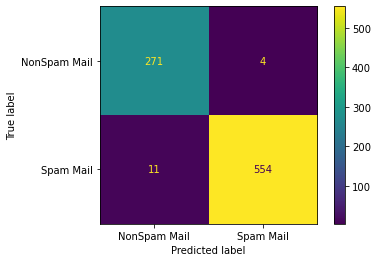

In [117]:
cm = confusion_matrix(predictions_OG, y_test)
target_names = ['NonSpam Mail', 'Spam Mail']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()
print("Confusion Matrix")
plt.draw()

In [118]:
len(predictions_OG)

840

In [119]:
#get the False Neg Rates: 
from sklearn.metrics import recall_score
tpr = recall_score(y_test, predictions_OG) 
tnr = recall_score(y_test, predictions_OG) 
fpr = 1 - tnr
fnr = 1 - tpr

print('False Negative Rate: {:.3f}%'.format(fnr))   #FNR for 1st class will be at index 0

False Negative Rate: 0.007%


In [120]:
print("Classificaion Report")

target_names = ['NonSpam Mail', 'Spam Mail']
print(classification_report(y_test, predictions_OG, digits=3, target_names=target_names))
cf = classification_report(y_test, predictions_OG, digits=3, target_names=target_names)

Classificaion Report
              precision    recall  f1-score   support

NonSpam Mail      0.985     0.961     0.973       282
   Spam Mail      0.981     0.993     0.987       558

    accuracy                          0.982       840
   macro avg      0.983     0.977     0.980       840
weighted avg      0.982     0.982     0.982       840



In [121]:
correct_doc = (y_test == predictions_OG).sum()
numbs_doc_wrong = X_test.shape[0] - correct_doc
print('Docs classified correctly', correct_doc)
print('Docs classified incorrectly', numbs_doc_wrong)

# fraction_wrong = numbs_doc_wrong/ (correct_doc +numbs_doc_wrong)
# print(f' The (testing) accuracy of the model is {1-fraction_wrong:.3%}')

accuracy = accuracy_score(y_test, predictions_OG)
print('SGD Classifier Accuracy of the model: {:.3f}%'.format(accuracy*100))

Docs classified correctly 825
Docs classified incorrectly 15
SGD Classifier Accuracy of the model: 98.214%


In [122]:
y__test = np.asarray(y_test)
misclassified = np.where(y__test != predictions_OG)
for x in misclassified: 
    misclass_data = data.MESSAGE[x]
    print(misclass_data)

Doc_ID
91     OWOLABI & ASSOCIATE,\n\nFALOMO, IKOYI.\n\nLAGO...
125    <HTML>\n\n<BODY>\n\n  <tr valign=3D"top"> \n\n...
171    <html>\n\n<head>\n\n</head>\n\n<body>\n\n\n\n<...
188    \n\n       Socijalisticka partija Srbije, pred...
216    Immediate Help Needed.  We are a fortune 500 c...
261    This is a multi-part message in MIME format.\n...
321    <HTML><HEAD><TITLE></TITLE><META http-equiv=3D...
327    ààªÍ¶¯ÄÔÇ¤ªäêé\n\nµ¶ÝÆààÌ...
364    When America's top companies compete for your ...
376    NEED Health Insurance? \n\n In addition to fea...
431    \n\nDear Sir or Madam\n\n\n\nIn the past you h...
448    <HTML><HEAD><TITLE>Lowest Rate Services</TITLE...
471    HI,  zzzz@spamassassin.taint.org   today,\n\n<...
667    <HTML><FONT  SIZE=3D2 PTSIZE=3D10 FAMILY=3D"SA...
729    <html>\n\n<head>\n\n   <meta http-equiv="Conte...
Name: MESSAGE, dtype: object


In [123]:
cleaned_misclass = misclass_data.apply(clean_msg_nohtml)
cleaned_misclass

Doc_ID
91     [OWOLABI, ASSOCIATE, FALOMO, IKOYI, LAGOS, NIG...
125    [eBay, Rated, Work, Home, Business, Opportunit...
171    [Save, Term, Life, Insurance, Compare, rates, ...
188    [Socijalisticka, partija, Srbije, predvodjena,...
216    [Immediate, Help, Needed, fortune, company, gr...
261    [message, MIME, format, homeowners, ca, wrong,...
321    [Newsletter, Discover, Tomorrow, Winners, Imme...
327    [Unsubscribe, send, mail, majordomo, unsubscri...
364    [America, companies, compete, business, win, t...
376    [NEED, Health, Insurance, addition, featuring,...
431    [Dear, Sir, Madam, past, requested, informatio...
448    [Lowest, Rate, Services, Conferencing, Easy, C...
471    [HI, zzzz, today, Ink, Price, like, spacial, o...
667    [Congratulations, mortgage, approved, Click, r...
729    [Herbal, Alternative, Erectile, Dysfunction, M...
Name: MESSAGE, dtype: object

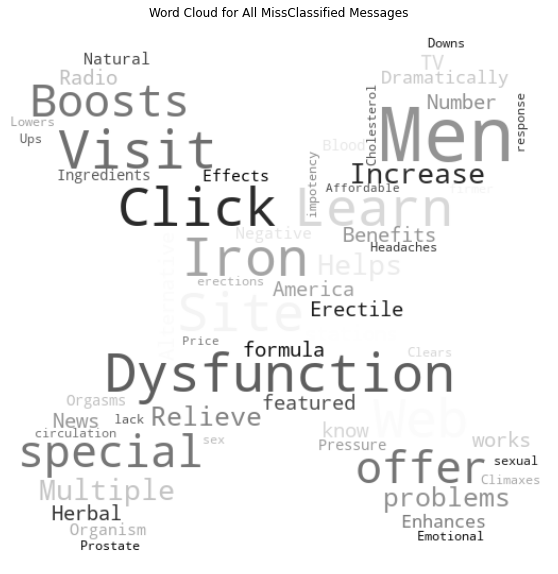

In [124]:
for x in cleaned_misclass:
    cleaned_misclass_string = (' '.join(x))
    
icon = Image.open(X_ICON)
image_mask = Image.new(mode = 'RGB', size = icon.size, color=(255,255,255))
image_mask.paste(icon, box = icon) 

rgb_array = np.array(image_mask) #converts the image object to an array 

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                       max_words = 100, colormap = 'gray')

word_cloud.generate(cleaned_misclass_string)

plt.figure(figsize=[16,10])
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.title('Word Cloud for All MissClassified Messages')
plt.axis('off')
plt.show()

In [125]:
from collections import Counter
counted_misclass = Counter(pd.Series(cleaned_misclass_string).str.split().sum())

In [ ]:
# missclass_most_common = counted_misclass.most_common()
# missclass_most_common[:5]

In [126]:
missclass_data1 = pd.DataFrame.from_dict(Counter(cleaned_misclass_string.split()).most_common(5))
missclass_data1 = missclass_data1.rename(columns={0: "words of missclassed", 1 : "count"})
missclass_data1

,words of missclassed,count
0,Men,2
1,Iron,2
2,Visit,2
3,Web,2
4,Site,2


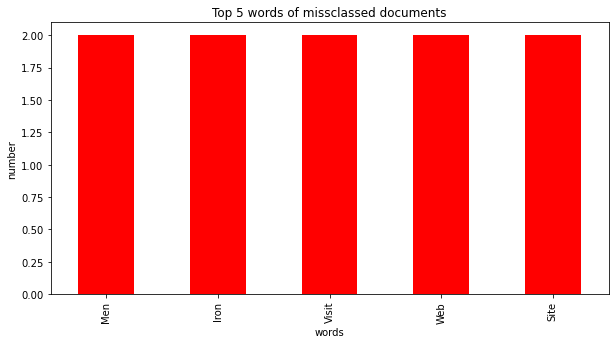

In [127]:
missclass_data1.plot.bar(legend = False, color = 'red', figsize = (10,5))
y_pos = np.arange(len(missclass_data1["words of missclassed"]))
plt.xticks(y_pos, missclass_data1["words of missclassed"])
plt.title('Top 5 words of missclassed documents')
plt.xlabel('words')
plt.ylabel('number')
plt.draw()
plt.legend().set_visible(False)

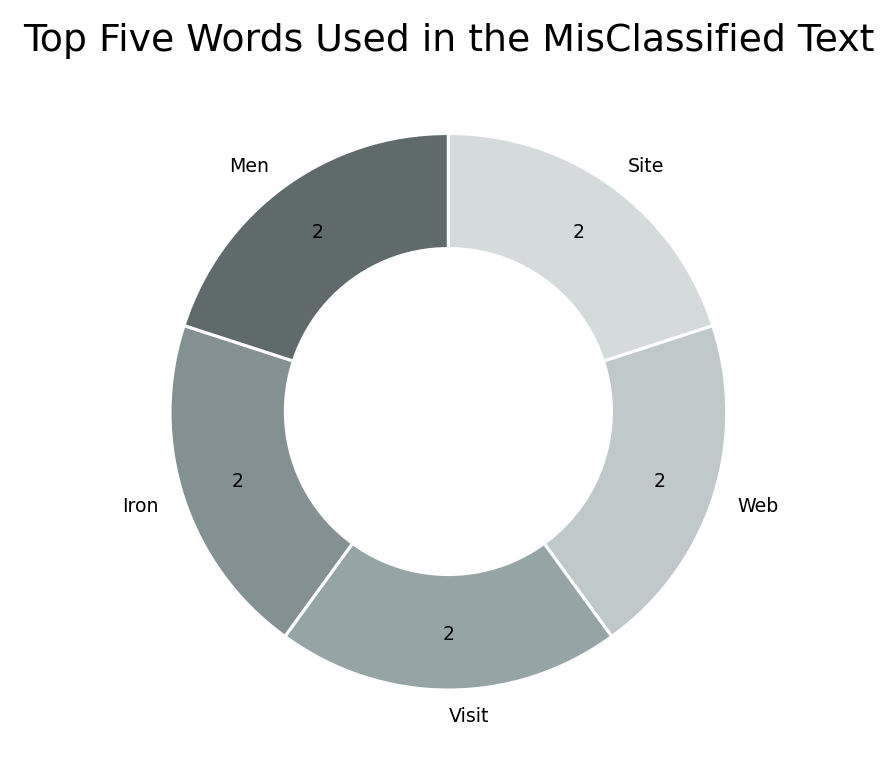

In [128]:
category_names = missclass_data1["words of missclassed"]

sizes = missclass_data1["count"]

custom_colours = ['#5F6A6A', '#839192', '#95A5A6',  '#BFC9CA', '#D5DBDB']

#to "explode"
offset = [0.01, 0.01, 0.01, 0.01, 0.01]

def absolute_value(val):
    a  = sizes[ np.abs(sizes - val/100.*sizes.sum()).argmin() ]
    return a

plt.figure(figsize=(4, 4), dpi=227)
plt.pie(sizes, labels = category_names, textprops={'fontsize':6}, startangle=90, 
        autopct=absolute_value, colors = custom_colours,  pctdistance = 0.8, explode = offset)


#draw circle
centre_circle = plt.Circle((0,0), radius = 0.6, fc='white')
plt.gca().add_artist(centre_circle)


#title
plt.title('Top Five Words Used in the MisClassified Text')

plt.show()

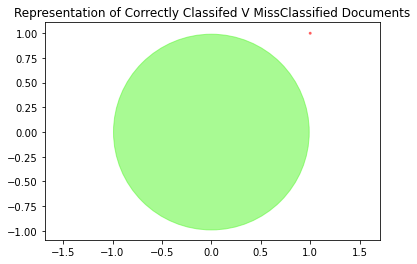

In [129]:
fig, ax = plt.subplots()
ax.add_patch(plt.Circle((0, 0), .99, color='#52F729', alpha=0.5))
ax.add_patch(plt.Circle((1, 1), .01, color='red', alpha=0.5))

#Use adjustable='box-forced' to make the plot area square-shaped as well.
ax.set_aspect('equal', adjustable='datalim')
plt.title('Representation of Correctly Classifed V MissClassified Documents')
#plt.axis('off')
ax.plot()   #Causes an autoscale update.
plt.show()


In [130]:
verify_tfidf_test = tfidf_vectorizer.transform(verification_data.MESSAGE)
validation = spam_detector_svc_OG.predict(verify_tfidf_test)
verification_data_category = verification_data.CATEGORY.to_numpy()
#len(validation)

In [131]:
correct_doc_val = (verification_data_category == validation).sum()
numbs_doc_wrong_val = verification_data_category.shape[0] - correct_doc_val
print('Docs classified correctly', correct_doc_val)
print('Docs classified incorrectly', numbs_doc_wrong_val)

Docs classified correctly 979
Docs classified incorrectly 12


Confusion Matrix


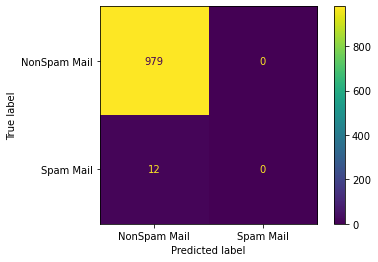

In [132]:
cm_validation = confusion_matrix(validation, verification_data_category)
target_names = ['NonSpam Mail', 'Spam Mail']
disp = ConfusionMatrixDisplay(confusion_matrix=cm_validation, display_labels=target_names)
disp.plot()
print("Confusion Matrix")
plt.draw()